# ADS 508 Final Project

By: Christopher Garcia, Claire Phibbs, and Christine Vu

## Diabetes Health Indicators Dataset:
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

## Loading in Necessary Libraries 

In [55]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

## Ingesting the Data into AWS S3 and SageMaker

In [6]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name = "sagemaker", region_name = region)

In [7]:
ingest_create_athena_db_passed = False

In [8]:
# viewing the s3 bucket content to confirm the 3 csv files are there
!aws s3 ls s3://diabetes-ads508/folder-1/csv/
!aws s3 ls s3://diabetes-ads508/folder-2/csv/
!aws s3 ls s3://diabetes-ads508/folder-3/csv/

2023-03-20 21:38:19          0 
2023-03-20 21:39:29   11829910 diabetes_012_health_indicators_BRFSS2015.csv
2023-03-20 21:38:28          0 
2023-03-20 21:40:39    3307813 diabetes_binary_5050split_health_indicators_BRFSS2015.csv
2023-03-20 21:38:41          0 
2023-03-20 21:40:55   11829913 diabetes_binary_health_indicators_BRFSS2015.csv


In [9]:
# set source location of public s3 bucket
s3_public_path = "s3://diabetes-ads508/folder-1/csv"
%store s3_public_path

s3_public_path_2 = "s3://diabetes-ads508/folder-2/csv"
%store s3_public_path_2

Stored 's3_public_path' (str)
Stored 's3_public_path_2' (str)


In [10]:
# set distination location of private s3 bucket
s3_private_path = "s3://{}/diabetes-ads508/folder-1/csv".format(bucket)
print(s3_private_path)
%store s3_private_path

s3_private_path_2 = "s3://{}/diabetes-ads508/folder-2/csv".format(bucket)
print(s3_private_path_2)
%store s3_private_path_2

s3://sagemaker-us-east-1-517122314325/diabetes-ads508/folder-1/csv
Stored 's3_private_path' (str)
s3://sagemaker-us-east-1-517122314325/diabetes-ads508/folder-2/csv
Stored 's3_private_path_2' (str)


In [11]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "diabetes_012_health_indicators_BRFSS2015.csv"
!aws s3 cp --recursive $s3_public_path_2/ $s3_private_path_2/ --exclude "*" --include "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

copy: s3://diabetes-ads508/folder-1/csv/diabetes_012_health_indicators_BRFSS2015.csv to s3://sagemaker-us-east-1-517122314325/diabetes-ads508/folder-1/csv/diabetes_012_health_indicators_BRFSS2015.csv
copy: s3://diabetes-ads508/folder-2/csv/diabetes_binary_5050split_health_indicators_BRFSS2015.csv to s3://sagemaker-us-east-1-517122314325/diabetes-ads508/folder-2/csv/diabetes_binary_5050split_health_indicators_BRFSS2015.csv


In [12]:
# list files in the private s3 bucket
print(s3_private_path)
print(s3_private_path_2)

s3://sagemaker-us-east-1-517122314325/diabetes-ads508/folder-1/csv
s3://sagemaker-us-east-1-517122314325/diabetes-ads508/folder-2/csv


In [13]:
# checking files copied to private bucket successfully
!aws s3 ls $s3_private_path/
!aws s3 ls $s3_private_path_2/

2023-03-21 00:48:32   11829910 diabetes_012_health_indicators_BRFSS2015.csv
2023-03-21 00:48:34    3307813 diabetes_binary_5050split_health_indicators_BRFSS2015.csv


### Creating Athena Database

In [14]:
# create database
database_name = "diabetes"

In [15]:
 # Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [16]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [17]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name) 
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS diabetes


""


In [18]:
# verifying database diabetes has been created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,default
1,diabetes
2,diabetes_indicators


### Registering S3 Bucket with Athena 

In [19]:
# set athena parameters
database_name = "diabetes"
table_name = "diabetes_indicators"
table_name_2 = "diabetes_binary_5050split"

In [20]:
pd.read_sql(f'DROP TABLE IF EXISTS diabetes.diabetes_indicators', conn)
pd.read_sql(f'DROP TABLE IF EXISTS diabetes.diabetes_binary_5050split', conn)

""


In [21]:
diabetes_indicators_table = f"""CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                Diabetes_012 int,
                HighBP int,
                HighChol int,
                CholCheck int,
                BMI int,
                Smoker int,
                Stroke int, 
                HeartDisease int,
                PhysActivity int,
                Fruits int,
                Veggies int,
                HvyAlcoholConsump int,
                AnyHealthCare int,
                NoDocbcCost int,
                GenHlth int,
                MentHlth int,
                PhysHlth int,
                DiffWalk int,
                Sex int,
                Age int,
                Education int,
                Income int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' 
LOCATION 's3://diabetes-ads508/folder-1/csv'
TBLPROPERTIES ('classification' = 'csv', 'skip.header.line.count'='1')"""

pd.read_sql(diabetes_indicators_table, conn)

""


In [22]:
diabetes_binary_5050split_table = f"""CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_2}(
                Diabetes_binary int,
                HighBP int,
                HighChol int,
                CholCheck int,
                BMI int,
                Smoker int,
                Stroke int, 
                HeartDisease int,
                PhysActivity int,
                Fruits int,
                Veggies int,
                HvyAlcoholConsump int,
                AnyHealthCare int,
                NoDocbcCost int,
                GenHlth int,
                MentHlth int,
                PhysHlth int,
                DiffWalk int,
                Sex int,
                Age int,
                Education int,
                Income int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' 
LOCATION 's3://diabetes-ads508/folder-2/csv'
TBLPROPERTIES ('classification' = 'csv', 'skip.header.line.count'='1')"""

pd.read_sql(diabetes_binary_5050split_table, conn)

""


In [23]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head()

,tab_name
0,diabetes_binary_5050split
1,diabetes_indicators


In [24]:
# confirming creation of table
statement = """SELECT * FROM diabetes.diabetes_indicators LIMIT 5"""
pd.read_sql(statement, conn)

,diabetes_012,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdisease,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


In [25]:
# confirming creation of table
statement = """SELECT * FROM diabetes.diabetes_binary_5050split LIMIT 5"""
pd.read_sql(statement, conn)

,diabetes_binary,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdisease,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,0,1,26,0,0,0,1,0,...,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,...,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,...,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,...,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,...,1,0,2,0,0,0,0,8,5,8


### Creating Data Frames of the Ingested Data

In [29]:
# Creating pandas df from query
statement = """SELECT * FROM diabetes.diabetes_indicators"""
diabetes_indicators_df = pd.read_sql(statement, conn)
diabetes_indicators_df.head()

,diabetes_012,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdisease,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


In [30]:
# Creating pandas df from query
statement = """SELECT * FROM diabetes.diabetes_binary_5050split"""
diabetes_binary_5050split_df = pd.read_sql(statement, conn)
diabetes_binary_5050split_df.head()

,diabetes_binary,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdisease,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,0,1,26,0,0,0,1,0,...,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,...,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,...,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,...,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,...,1,0,2,0,0,0,0,8,5,8


## Exploratory Data Analysis (EDA):

In [57]:
# Shape of dataframes
print("Diabetes Shape:", diabetes_indicators_df.shape)
print("Diabetes 50/50 Split Shape:", diabetes_binary_5050split_df.shape)

Diabetes Shape: (253680, 22)
Diabetes 50/50 Split Shape: (70692, 22)


In [61]:
# detecting missing values
print("Diabetes Missing Values:", diabetes_indicators_df.isna().sum())
print("Diabetes Missing Values:", diabetes_binary_5050split_df.isna().sum())

Diabetes Missing Values: diabetes_012         0
highbp               0
highchol             0
cholcheck            0
bmi                  0
smoker               0
stroke               0
heartdisease         0
physactivity         0
fruits               0
veggies              0
hvyalcoholconsump    0
anyhealthcare        0
nodocbccost          0
genhlth              0
menthlth             0
physhlth             0
diffwalk             0
sex                  0
age                  0
education            0
income               0
dtype: int64
Diabetes Missing Values: diabetes_binary      0
highbp               0
highchol             0
cholcheck            0
bmi                  0
smoker               0
stroke               0
heartdisease         0
physactivity         0
fruits               0
veggies              0
hvyalcoholconsump    0
anyhealthcare        0
nodocbccost          0
genhlth              0
menthlth             0
physhlth             0
diffwalk             0
sex              

In [62]:
# Data types of all columns
print("Diabetes Data Types:\n", diabetes_indicators_df.dtypes)
print("\nDiabetes 50/50 Split Data Types:\n", diabetes_binary_5050split_df.dtypes)

Diabetes Data Types:
 diabetes_012         int64
highbp               int64
highchol             int64
cholcheck            int64
bmi                  int64
smoker               int64
stroke               int64
heartdisease         int64
physactivity         int64
fruits               int64
veggies              int64
hvyalcoholconsump    int64
anyhealthcare        int64
nodocbccost          int64
genhlth              int64
menthlth             int64
physhlth             int64
diffwalk             int64
sex                  int64
age                  int64
education            int64
income               int64
dtype: object

Diabetes 50/50 Split Data Types:
 diabetes_binary      int64
highbp               int64
highchol             int64
cholcheck            int64
bmi                  int64
smoker               int64
stroke               int64
heartdisease         int64
physactivity         int64
fruits               int64
veggies              int64
hvyalcoholconsump    int64
anyhealthca

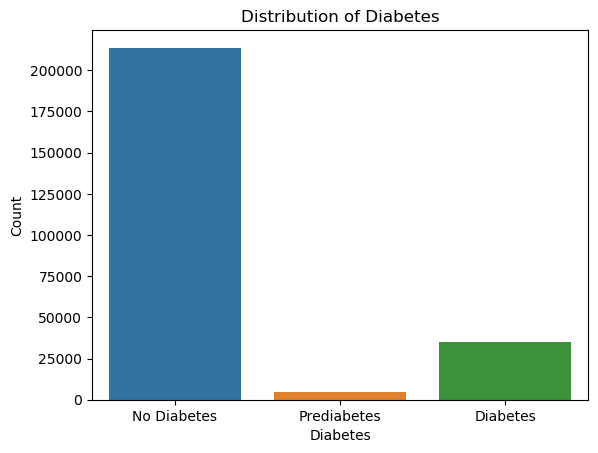

In [41]:
# Bar plot: Distribution of diabetes
# Get the count of diabetes values
diabetes_count = diabetes_indicators_df['diabetes_012'].value_counts()

# Create a bar plot
fig, ax = plt.subplots()
sns.barplot(x = diabetes_count.index, y = diabetes_count.values, ax = ax)
ax.set_xticklabels(['No Diabetes', 'Prediabetes', 'Diabetes'])
ax.set_xlabel('Diabetes')
ax.set_ylabel('Count')
ax.set_title('Distribution of Diabetes')
plt.show()

*We can see from the bar graph above that the diabetes_indicators_df has a 3 class target variable (diabetes_012) and it is quite imbalanced, with a majority of the responses being 0 (i.e., no diabetes).*

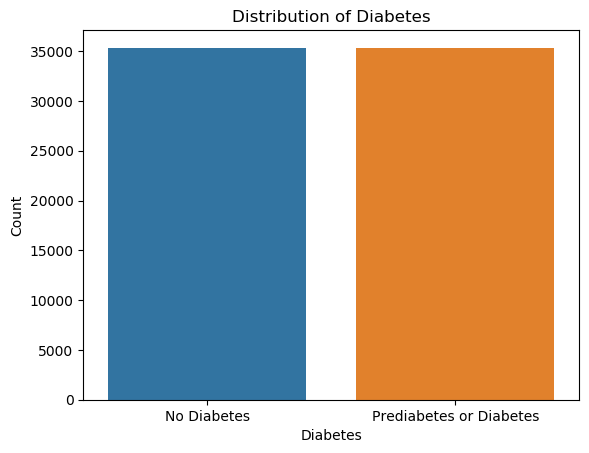

In [42]:
# Bar plot: Distribution of diabetes
# Get the count of diabetes values
diabetes_count = diabetes_binary_5050split_df['diabetes_binary'].value_counts()

# Create a bar plot
fig, ax = plt.subplots()
sns.barplot(x = diabetes_count.index, y = diabetes_count.values, ax = ax)
ax.set_xticklabels(['No Diabetes', 'Prediabetes or Diabetes'])
ax.set_xlabel('Diabetes')
ax.set_ylabel('Count')
ax.set_title('Distribution of Diabetes')
plt.show()

*From the bar graph above we can see that the diabetes_binary_5050split_df has a two class target variable (diabetes_binary) and the target variable has been balanced for us. Moving forwards we will be working with the diabetes_binary_5050split_df.*

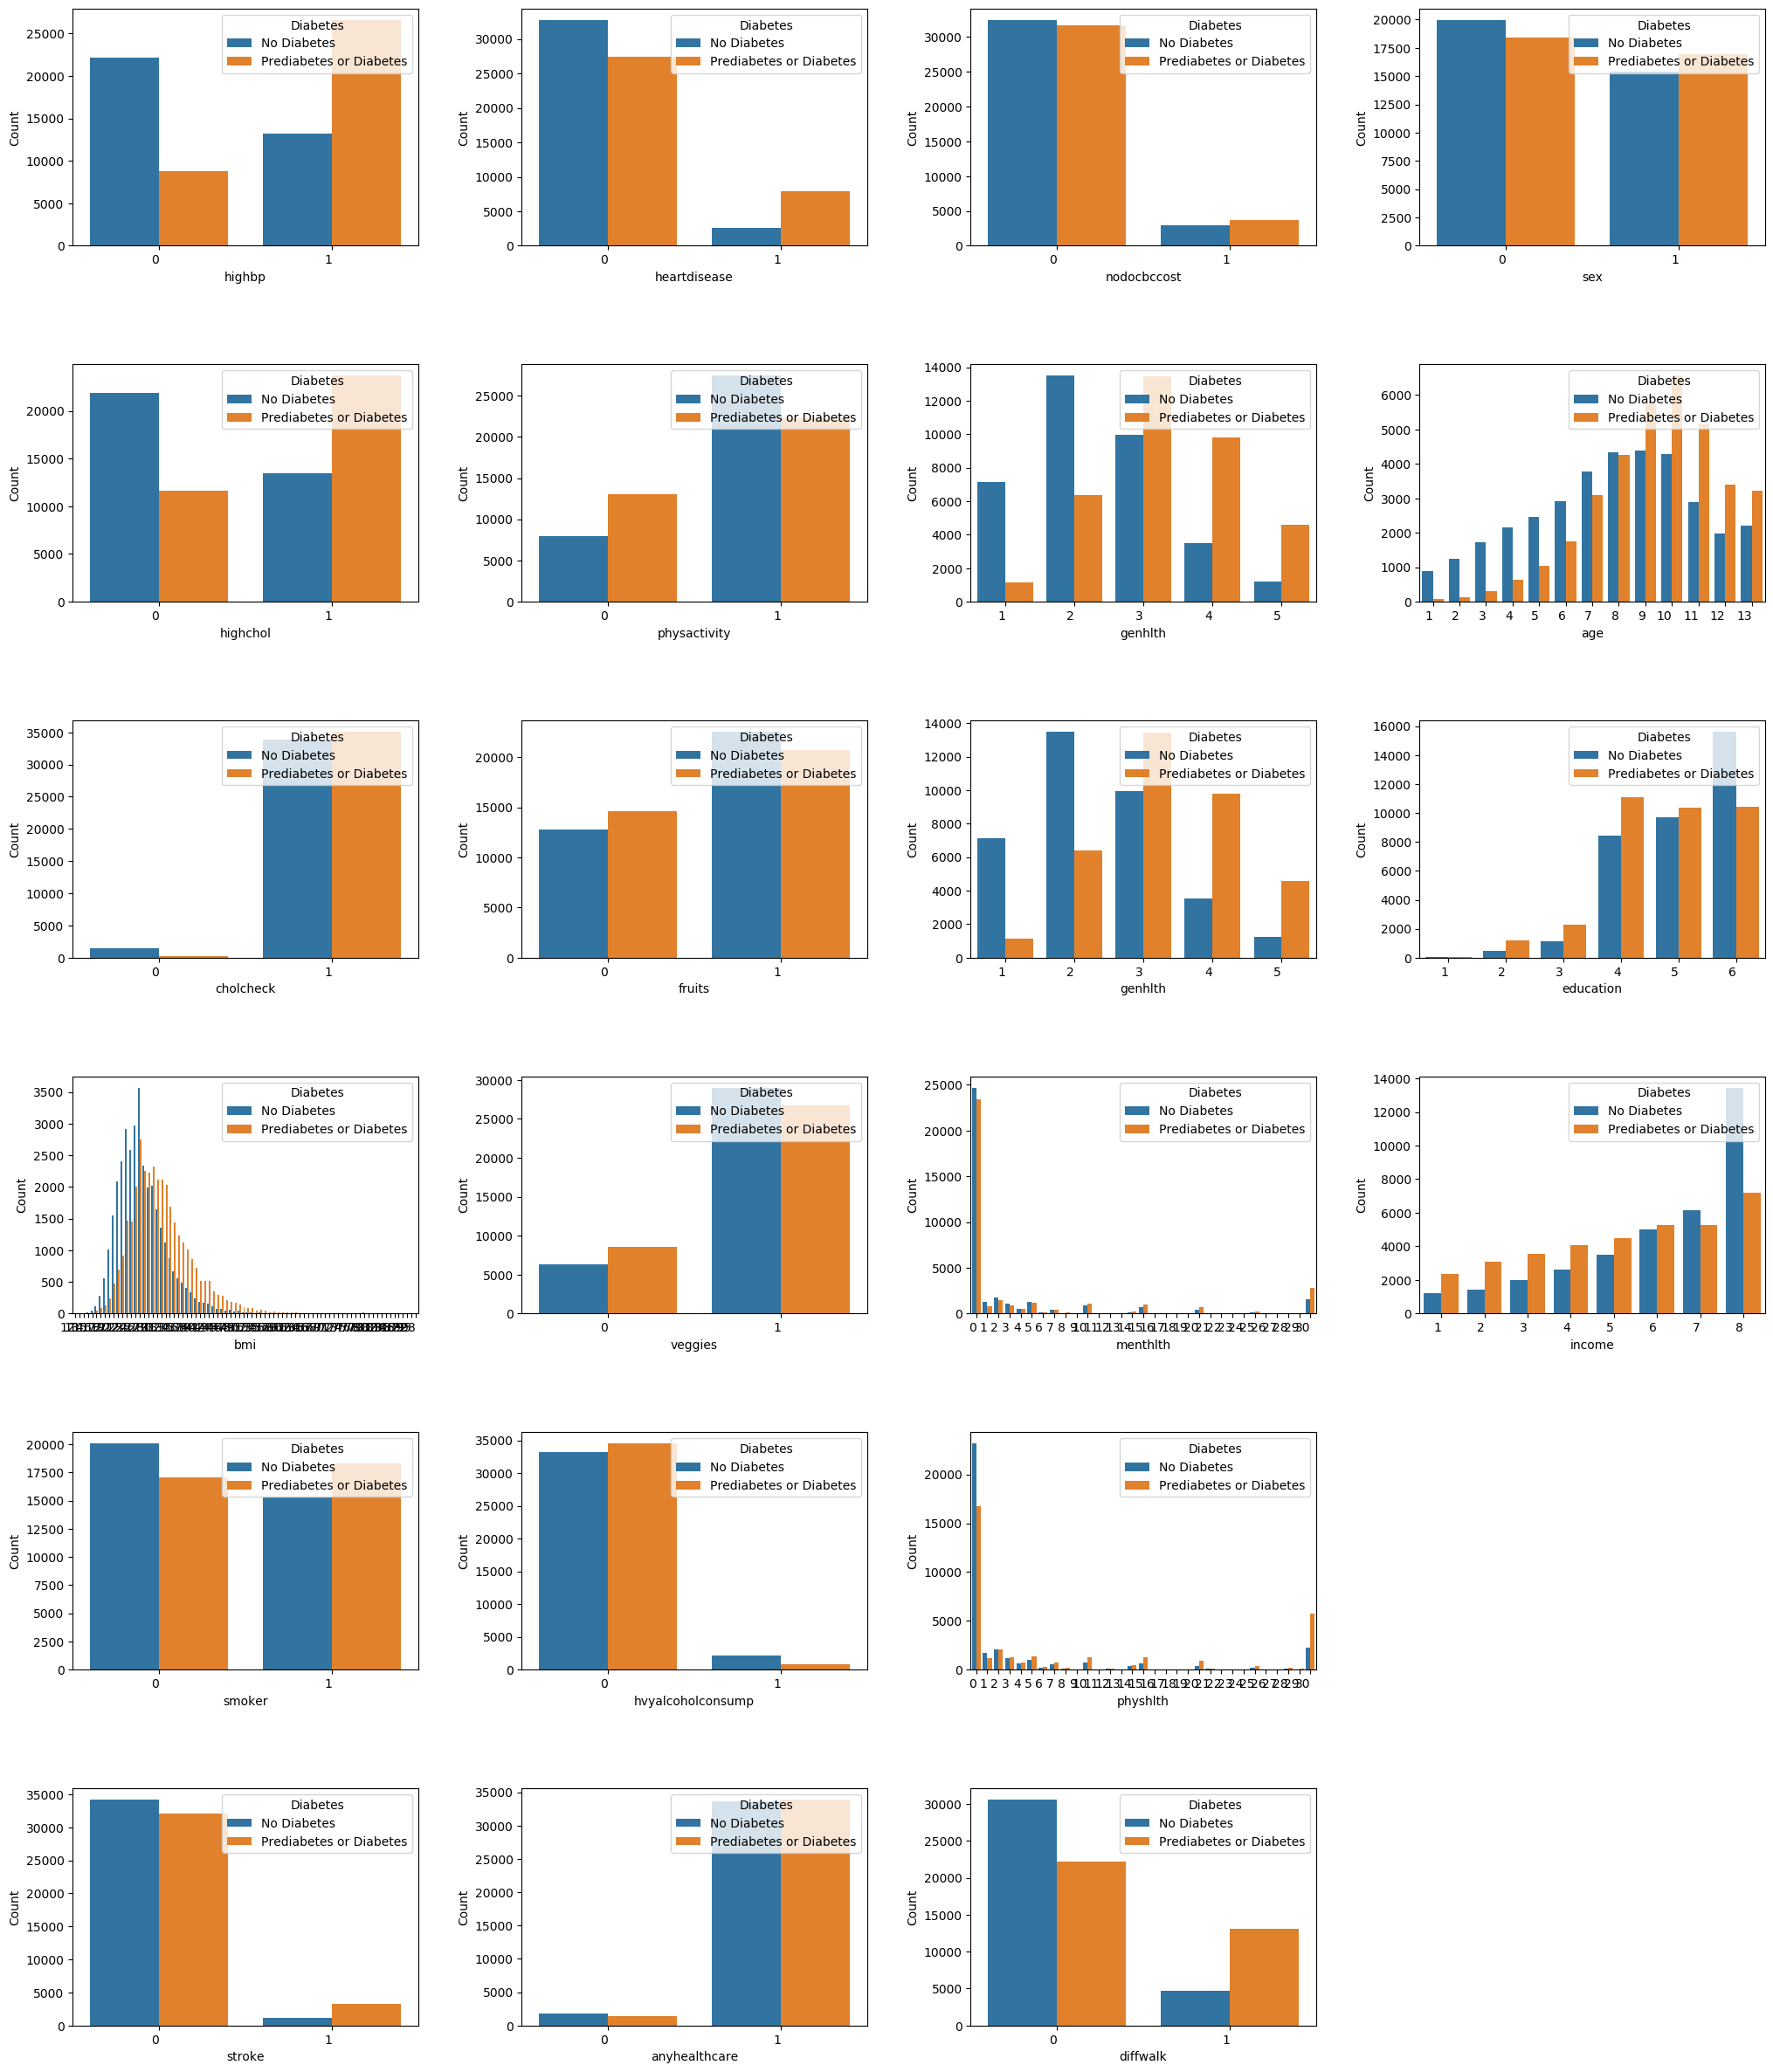

In [48]:
# Bar plot: Diabetes by predictor variables

predictors = ['highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke', 'heartdisease', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump',
              'anyhealthcare', 'nodocbccost', 'genhlth', 'genhlth', 'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education', 'income']

fig, axes = plt.subplots(6, 4, figsize = (25, 30))

# Create bar charts for each predictor variable
for i, pred in enumerate(predictors):
    # Calculate row and column indices
    row = i % 6
    col = i // 6

    # Create bar chart for each predictor variable
    fig = sns.countplot(x = pred, hue = 'diabetes_binary', data = diabetes_binary_5050split_df, ax = axes[row, col])
    fig.set_xticklabels(fig.get_xticklabels(), horizontalalignment = 'right')
    fig.set_xlabel(pred)
    fig.set_ylabel('Count')
    fig.legend(title = 'Diabetes', loc = 'upper right', labels = ['No Diabetes', 'Prediabetes or Diabetes'])

# Adjust the space between subplots
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

# Hide unused subplots
for j in range(i + 1, 24):
    row = j % 6
    col = j // 6
    axes[row, col].axis('off')

# Show the plot
plt.show()

<Figure size 5000x1500 with 0 Axes>

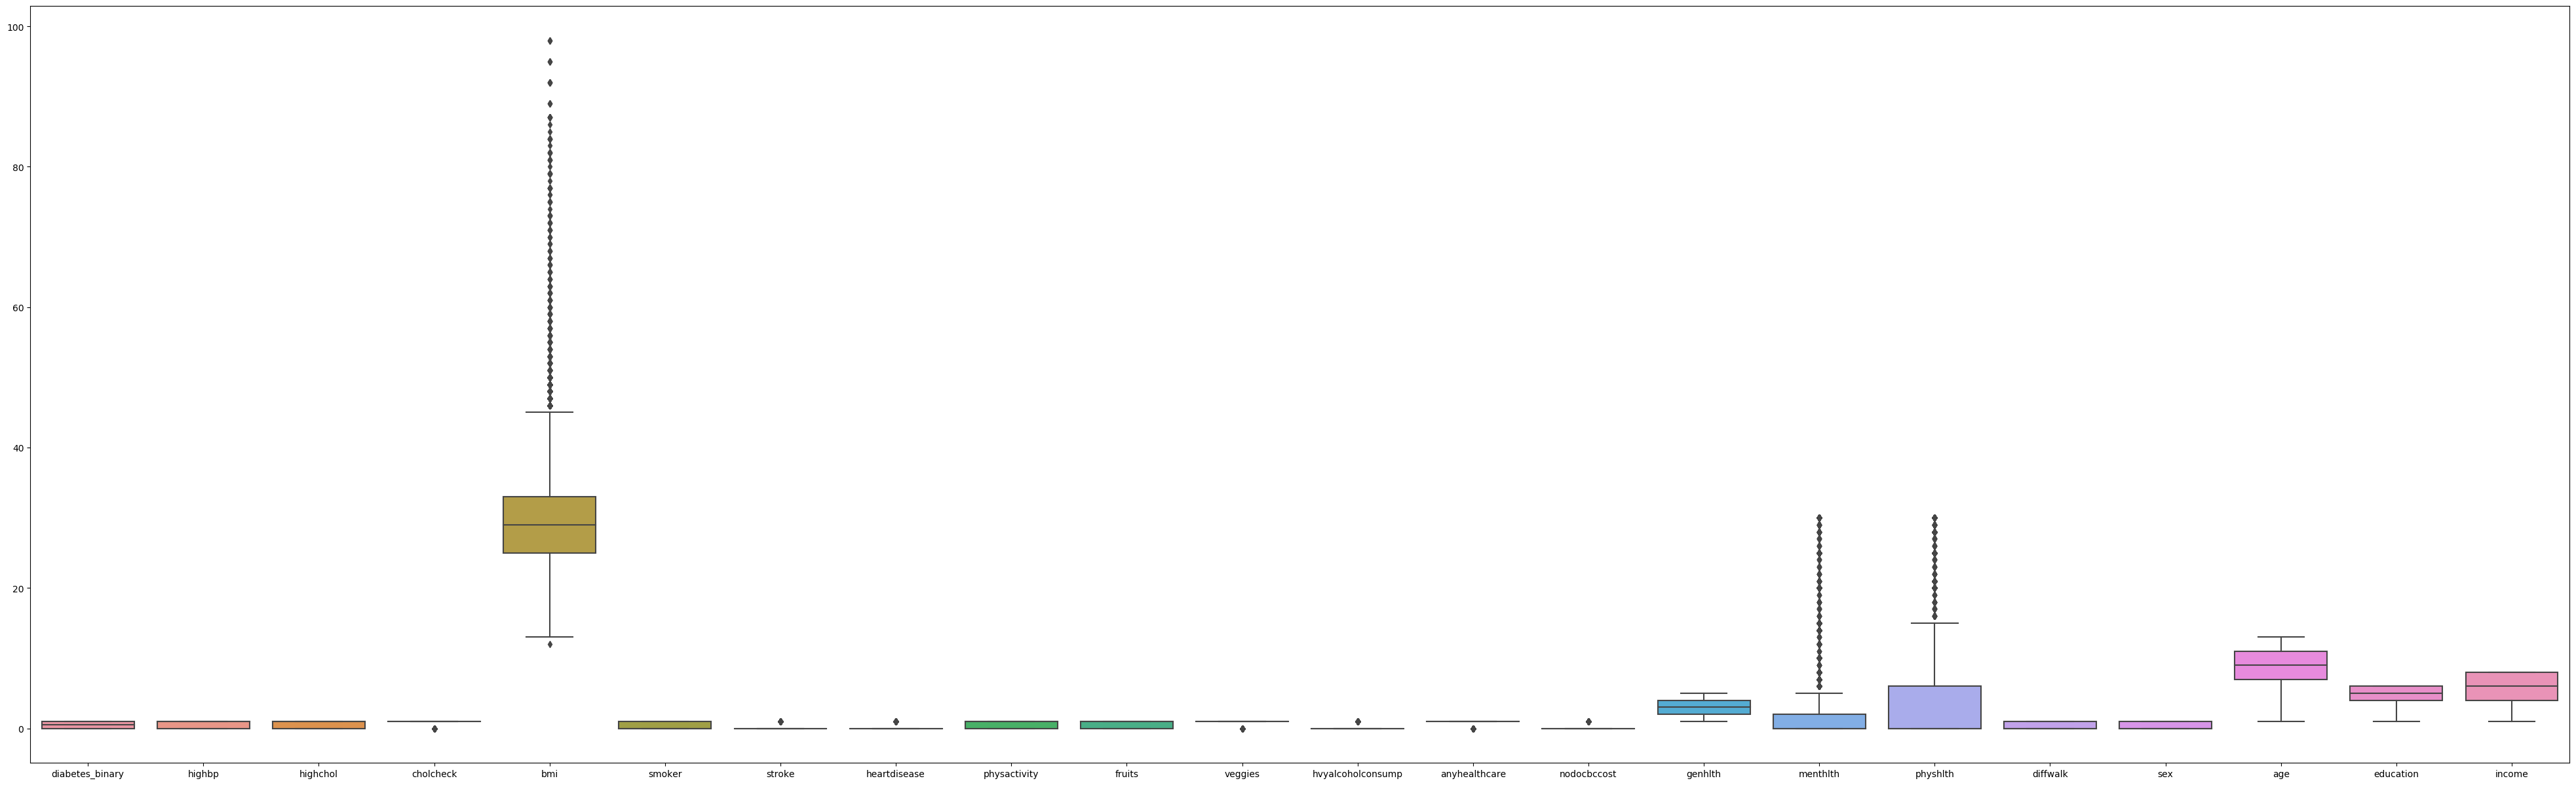

In [50]:
# Box plot: View outliers of Diabetes 50/50 Split dataframe
plt.figure(figsize = (50, 15))
sns.boxplot(data = diabetes_binary_5050split_df, orient = 'v')
plt.show()

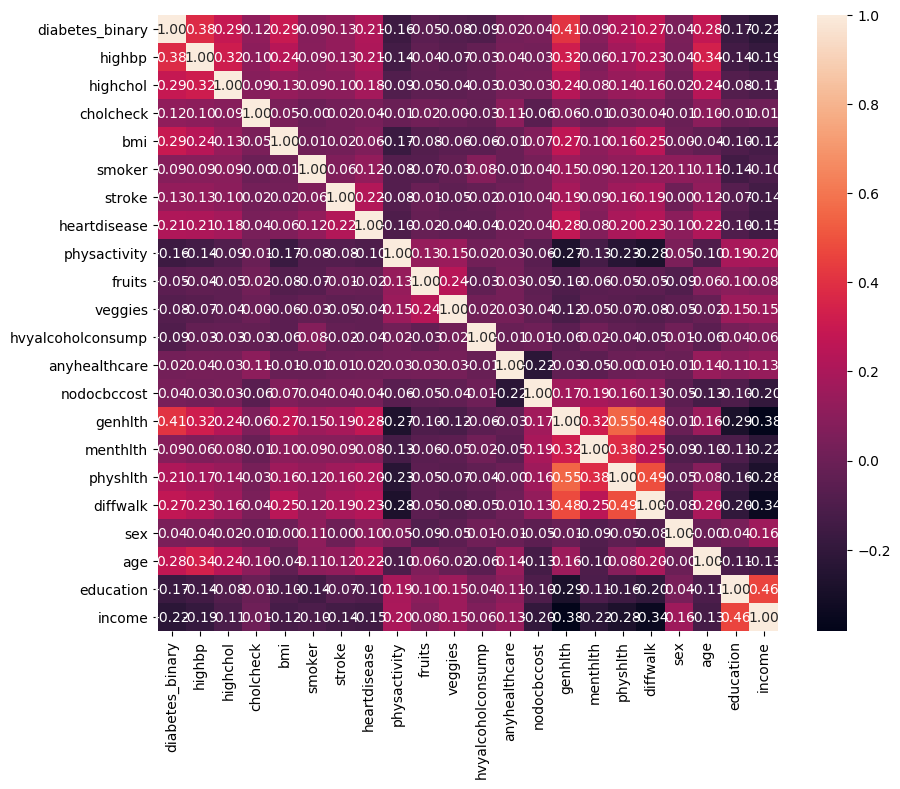

In [51]:
# Heat map: Correlation between all variables
plt.figure(figsize = (10,8))
sns.heatmap(diabetes_binary_5050split_df.corr(), annot = True, fmt = ".2f");
plt.show()